# 0. Подгружаем все необходимое

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_all = pd.read_csv('cmoa.csv')

df_all.head(3)

,title,creation_date,creation_date_earliest,creation_date_latest,medium,accession_number,id,credit_line,date_acquired,department,...,artist_id,party_type,full_name,cited_name,role,nationality,birth_date,death_date,birth_place,death_place
0,Keith Haring,1984,1984-01-01,1984-01-01,gelatin silver print,2002.17,cmoa:things/692a68c5-af1e-4124-80f1-cbf38be51abe,Milton Fine Fund,2002-06-06,Contemporary Art,...,cmoa:parties/2cb30976-c292-4060-9dea-ba0e9504dda7,Person,Robert Mapplethorpe,"Mapplethorpe, Robert",NaN,American,1947-01-01,1989-01-01,"New York City (New York state, United States)","New York City (New York state, United States)"
1,Untitled,1964-1965,1964-01-01,1965-01-01,oil on canvas,2002.19,cmoa:things/871505af-a072-4a84-ab09-3abf932951b8,Joseph Soffer Family Trust Fund,2002-06-06,Contemporary Art,...,cmoa:parties/b5cb7ad2-50ca-4c5b-8a80-74202ddfb9c2,Person,Jo Baer,"Baer, Jo",NaN,American,1929-01-01,NaN,"Seattle (King County, Washington, United States)",NaN
2,Trans East West (Tew) No. 5: The Attack of the...,1999,1999-01-01,1999-01-01,mixed media on paper,2002.18.1,cmoa:things/fe93f7e2-e4ca-455e-bdfa-ea9be22cce8a,Second Century Acquisition Fund,2002-06-06,Contemporary Art,...,cmoa:parties/4c7afe88-ebfe-4e3b-9010-9ddcb1e11674,Person,Franz Ackermann,"Ackermann, Franz",NaN,German,1963-01-01,NaN,"Neumarkt-Sankt Veit (Oberbayern, Bavaria, Germ...",NaN


# 1. Предобрабатываем данные

## Делаем более удобную таблицу

In [3]:
df_all.columns

Index(['title', 'creation_date', 'creation_date_earliest',
       'creation_date_latest', 'medium', 'accession_number', 'id',
       'credit_line', 'date_acquired', 'department', 'physical_location',
       'item_width', 'item_height', 'item_depth', 'item_diameter', 'web_url',
       'provenance_text', 'classification', 'image_url', 'artist_id',
       'party_type', 'full_name', 'cited_name', 'role', 'nationality',
       'birth_date', 'death_date', 'birth_place', 'death_place'],
      dtype='object')

Так как датасет содержит очень много странных и ненужных данных, я сделал срез по необходимым стобцам:
- title _(The main title that identifies the object or artwork. No multiples)_;
- birth_date _(The death date of the artist/creator. Precision may vary based on how much is known about the artist)_;
- nationality _(The nationality of the artist/creator)_;
- classification _(The name of a group to which the work belongs within the museum's classification scheme, based on similar characteristics)_;
- creation_date _(The human readable date of creation for the object)_;
- date_acquired _(The date the object became the legal property of the museum)_;
- medium _(Material of which this is this object/artwork is made)_;
- item_width _(The maximum width of the artwork/object in inches)_;
- item_height _(The maximum height of the artwork/object in inches)_;
- item_depth _(The maximum depth of the artwork/object in inches)_

__P.S.__ вручную проверил ссылки, они оказались нерабочими

In [4]:
col =['title', 'classification', 'date_acquired', 'creation_date', 'medium', 'item_width', 
      'item_height', 'item_depth', 'birth_date', 'nationality']

In [5]:
df = df_all[col]

df.head(3)

,title,classification,date_acquired,creation_date,medium,item_width,item_height,item_depth,birth_date,nationality
0,Keith Haring,photographs,2002-06-06,1984,gelatin silver print,23.25,29.250,1.25,1947-01-01,American
1,Untitled,paintings,2002-06-06,1964-1965,oil on canvas,60.50,48.250,2.25,1929-01-01,American
2,Trans East West (Tew) No. 5: The Attack of the...,drawings and watercolors,2002-06-06,1999,mixed media on paper,7.50,5.125,0.00,1963-01-01,German


## Смотрим свойства таблицы

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28269 entries, 0 to 28268
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           28154 non-null  object 
 1   classification  28267 non-null  object 
 2   date_acquired   27852 non-null  object 
 3   creation_date   26683 non-null  object 
 4   medium          28131 non-null  object 
 5   item_width      28269 non-null  float64
 6   item_height     28269 non-null  float64
 7   item_depth      28269 non-null  float64
 8   birth_date      22696 non-null  object 
 9   nationality     28227 non-null  object 
dtypes: float64(3), object(7)
memory usage: 2.2+ MB


In [7]:
df.describe()

,item_width,item_height,item_depth
count,28269.000000,28269.000000,28269.000000
mean,16.469858,16.580439,1.471958
std,21.146298,59.342263,6.405482
min,0.000000,0.000000,0.000000
25%,6.812000,7.250000,0.000000
50%,13.438000,13.500000,0.000000
75%,21.250000,21.000000,0.375000
max,1296.000000,9600.000000,426.000000


## Преобразовываем числовые переменные

Как видим, пропусков, к счастью, нет. Колонки с датами __date_acquired__, __birth_date__ и __creation_date__ представлены в виде   object. Для даты создания может быть указан интервал, в котором произведение было создано, для удобства работы с этой колонкой будем использовать середину этого интервала

In [8]:
#работаем с creation_date

df['creation_date'].fillna('no date', inplace=True)

first_date_l = []
second_date_l = []

for date in df['creation_date']:
    clear_date = re.findall(r'\d+', date)
    
    if len(clear_date) == 1:
        if len(clear_date[0]) == 4:
            first_date = int(clear_date[0])
            second_date = int(clear_date[0])
        else: 
            first_date = np.nan
            second_date = np.nan
    if len(clear_date) == 2:
        if len(clear_date[0]) == 4 and len(clear_date[1]) == 4:
            first_date = int(clear_date[0])
            second_date = int(clear_date[1])
        else: 
            first_date = np.nan
            second_date = np.nan

    first_date_l.append(first_date)
    second_date_l.append(second_date)

В процессе обработки этого столбца обнаружилось, что усреднение по очень большому размаху не совсем правильно, поэтому при различии границ интервала больше, чем на 70 я решил проставить np.nan

In [9]:
df_date = df[['title', 'creation_date']]
df_date['first_date'] = first_date_l
df_date['second_date'] = second_date_l
df_date['diff'] = df_date['second_date'] - df_date['first_date']

In [10]:
mask = df_date['diff'] > 50

df_date.loc[mask, 'first_date'] = np.nan
df_date.loc[mask, 'second_date'] = np.nan

In [11]:
df_date['date'] = round((df_date['second_date'] + df_date['first_date']) / 2)

df['creation_date'] = df_date['date']

Посмотрим на другие крайние значения даты создания

In [12]:
df['creation_date'].sort_values(ascending=False)

13295    3000.0
13907    2500.0
13995    2450.0
12174    2250.0
3983     2016.0
          ...  
27895       NaN
27896       NaN
27897       NaN
28157       NaN
28198       NaN
Name: creation_date, Length: 28269, dtype: float64

In [13]:
mask = [13295, 13907, 13995, 12174, 3983]
df_date.loc[mask]

,title,creation_date,first_date,second_date,diff,date
13295,Pot,c. 3000 BCE,3000.0,3000.0,0.0,3000.0
13907,Vase,c. 3000 BCE-2000 BCE,3000.0,2000.0,-1000.0,2500.0
13995,"Vessel, frying-pan",2700-2200 BCE,2700.0,2200.0,-500.0,2450.0
12174,Bust of a Woman,c. 2500 BCE-2000 BCE,2500.0,2000.0,-500.0,2250.0
3983,"Presentation model, Parque España Library, Med...",2016,2016.0,2016.0,0.0,2016.0


Видно, что некоторые даты не соответствуют действительности, так как 3000 год еще не наступил. Из таблицы становится ясно, что все дело в странном формате данных. Просто выбросим эти года

In [14]:
df.loc[mask, 'creation_date'] = np.nan

In [15]:
#работаем с birth_date

correct = []
df['birth_date'].fillna('0-', inplace=True)
for date in df['birth_date']:
    if date[0].isdigit():
        date = date.split('-')[0]
        correct.append(int(date))
    else:
        correct.append(np.nan)

df['birth_date'] = correct
df['birth_date'].replace(0, np.nan, inplace=True)

Посмотрим крайние полученные значения

In [16]:
df['birth_date'].sort_values()[:10]

12176     699.0
7853      700.0
7851      700.0
14552     800.0
14553     800.0
13862     800.0
12792    1200.0
12149    1200.0
12134    1200.0
21190    1222.0
Name: birth_date, dtype: float64

In [17]:
df['birth_date'].sort_values(ascending = False)[:10]

14169    2016.0
3732     2006.0
4306     2004.0
4308     2004.0
4309     2004.0
4305     2004.0
4304     2004.0
4302     2004.0
4310     2004.0
4307     2004.0
Name: birth_date, dtype: float64

In [18]:
df_all.loc[[12176, 7853, 7851, 14552, 14553, 13862, 12792, 12149, 12134, 21190]]

,title,creation_date,creation_date_earliest,creation_date_latest,medium,accession_number,id,credit_line,date_acquired,department,...,artist_id,party_type,full_name,cited_name,role,nationality,birth_date,death_date,birth_place,death_place
12176,Pin,c. 699-500 BCE,-0704-01-09,-0495-01-06,bronze,70.28,cmoa:things/e01ced9f-5189-4794-b7fa-0ac825a596f9,Greta S. Heckett Fund,1970-05-07,Decorative Arts and Design,...,cmoa:parties/48705471-faae-43a9-9f5a-e9a2748d51ee,Person,"unknown Persian, Achaemenid period","unknown Persian, Achaemenid period",NaN,Achaemenid,0699-01-01,0599-01-01,NaN,NaN
7853,Jar,618-906,0617-12-29,0905-12-27,Ceramic,25.1.18,cmoa:things/5dbd5bcc-6b04-4214-97bc-3a12ce3b15dd,Gift of Charles D. Armstrong,1925-01-01,Decorative Arts and Design,...,cmoa:parties/93e30e53-8172-4b7c-819c-8d9703f61565,Person,"unknown Chinese, T'Ang dynasty","unknown Chinese, T'Ang dynasty",NaN,Chinese,0700-01-01,0750-01-01,NaN,NaN
7851,Jar,618-906,0617-12-29,0905-12-27,earthenware,25.1.17,cmoa:things/15744366-c9c5-4725-a396-37954ea49150,Gift of Charles D. Armstrong,1925-01-01,Decorative Arts and Design,...,cmoa:parties/93e30e53-8172-4b7c-819c-8d9703f61565,Person,"unknown Chinese, T'Ang dynasty","unknown Chinese, T'Ang dynasty",NaN,Chinese,0700-01-01,0750-01-01,NaN,NaN
14552,Standard,c. 800 BCE,-0805-01-09,-0795-01-09,bronze with brown patina,77.41.1.A-B,cmoa:things/66228f0d-f386-44f2-baf2-852d0b04b003,Gift of Mr. and Mrs. Leon Anthony Arkus,1977-10-12,Decorative Arts and Design,...,cmoa:parties/30f24c18-af39-466b-aa0b-30234c2b8ee5,Person,"unknown Iranian, Lorestan","unknown Iranian, Lorestan",NaN,Iranian,0800-01-01,NaN,NaN,NaN
14553,Standard,c. 800 BCE,-0850-01-09,-0750-01-09,bronze with brown patina,77.41.2.A-C,cmoa:things/abd98496-ac01-4915-b44f-12695de49267,Gift of Mr. and Mrs. Leon Anthony Arkus,1977-10-12,Decorative Arts and Design,...,cmoa:parties/30f24c18-af39-466b-aa0b-30234c2b8ee5,Person,"unknown Iranian, Lorestan","unknown Iranian, Lorestan",NaN,Iranian,0800-01-01,NaN,NaN,NaN
13862,Standard,c. 800 BCE,-0805-01-09,-0795-01-09,luristan bronze,75.21.3.A-C,cmoa:things/da89f99f-a934-4351-9c10-e5cd2983bb45,Gift of Mr. and Mrs. Leon Anthony Arkus,1975-10-09,Decorative Arts and Design,...,cmoa:parties/30f24c18-af39-466b-aa0b-30234c2b8ee5,Person,"unknown Iranian, Lorestan","unknown Iranian, Lorestan",NaN,Iranian,0800-01-01,NaN,NaN,NaN
12792,Covered Bowl,c. 1200-1499,1194-12-25,1503-12-22,ceramic with blue underglaze,70.55.2.A-B,cmoa:things/e0197cdb-337c-4742-aeef-4a91e26ed8af,Gift of Mrs. Fred C. Foy,1970-12-17,Decorative Arts and Design,...,cmoa:parties/ae9cbe86-7144-417a-a65c-254d4eda4fdf,Person,"unknown Thai, Svargaloka","unknown Thai, Svargaloka",NaN,Thai,1200-01-01,1499-01-01,NaN,NaN
12149,Bowl,13th-15th century,1199-12-25,1498-12-23,glazed porcelain,70.1.1.A-B,cmoa:things/f9f2cc3a-047f-4a5f-88dd-2382a62edebe,Gift of Mrs. Fred C. Foy,1970-05-07,Decorative Arts and Design,...,cmoa:parties/ae9cbe86-7144-417a-a65c-254d4eda4fdf,Person,"unknown Thai, Svargaloka","unknown Thai, Svargaloka",NaN,Thai,1200-01-01,1499-01-01,NaN,NaN
12134,Bowl,13th-15th century,1199-12-25,1498-12-23,Earthenware,69.5.1.A-B,cmoa:things/14aee16b-d006-4639-bbd8-9f2c451f47eb,Gift of Mrs. Fred C. Foy,1969-04-24,Decorative Arts and Design,...,cmoa:parties/ae9cbe86-7144-417a-a65c-254d4eda4fdf,Person,"unknown Thai, Svargaloka","unknown Thai, Svargaloka",NaN,Thai,1200-01-01,1499-01-01,NaN,NaN
21190,Taishakuten (Buddhist),NaN,1241-12-25,1281-12-25,woodblock print on paper (block from 13th cent...,89.28.1092,cmoa:things/a8690b43-ef92-4112-a6d4-957316d0b89d,Bequest of Dr. James B. Austin,1989-12-07,Fine Arts,...,cmoa:parties/7f8407c3-8633-46a3-8e23-26f9ae3d0a4f,Person,Nichiren,Nichiren,attributed to,Japanese,1222-01-01,1282-01-01,Japan,NaN


Как видно из первоначальной таблицы, объекты под индексами 12176, 7853, 7851, 14552, 14553, 13862 датированы очень странно, так как верно интерпретировать эти значения не получится, придется их просто удалить

In [19]:
index = [12176, 7853, 7851, 14552, 14553, 13862]

In [20]:
df.loc[index, 'birth_date'] = np.nan

In [21]:
#работаем с date_acquired
correct = []
df['date_acquired'].fillna('no', inplace=True)

for date in df['date_acquired']:
    if date != 'no':
        date = int(date.split('-')[0])
    else:
        date = np.nan
    correct.append(date)
    
df['date_acquired'] = correct

## Преобразовываем категориальные переменные

In [22]:
df['nationality'].unique()[:10]

array(['American', 'German', 'Chinese', 'Italian|Italian',
       'British|Scottish', 'British', 'British|', 'British|British',
       'French', 'English|English'], dtype=object)

Как видно, в столбце __nationality__ могут лежать по несколько национальностей через знак __|__. Обычно авторство указывается согласно количеству вклада автора в работу, поэтому автор на первом месте "более важный". По такому принципу и сделаем в обрабатываемой колонке

In [23]:
df['nationality'].fillna('0', inplace=True)

correct = []

for nat in df['nationality']:
    if '|' in nat:
        nat_l = nat.split('|')
        nat = nat_l[0]
    correct.append(nat)

df['nationality'] = correct
df['nationality'].replace('0', np.nan, inplace=True)

In [24]:
print(len(df.medium.unique()))
df['medium'].unique()[:10]

5002


array(['gelatin silver print', 'oil on canvas', 'mixed media on paper',
       'glass', 'plastic, lead, glass and rubber',
       'plastic, lead, glass and rubber; set of five',
       'rock crystal and gilded copper', 'silver and silver gilt',
       'terracotta with underglaze decoration', 'salt-glazed stoneware'],
      dtype=object)

К сожалению, колонка __medium__ содержит очень много уникальных значений, которые не получиться как-то адекватно предобработать

Посмотрим что у нас получилось

In [25]:
df.head()

,title,classification,date_acquired,creation_date,medium,item_width,item_height,item_depth,birth_date,nationality
0,Keith Haring,photographs,2002.0,1984.0,gelatin silver print,23.250,29.250,1.25,1947.0,American
1,Untitled,paintings,2002.0,1964.0,oil on canvas,60.500,48.250,2.25,1929.0,American
2,Trans East West (Tew) No. 5: The Attack of the...,drawings and watercolors,2002.0,1999.0,mixed media on paper,7.500,5.125,0.00,1963.0,German
3,Trans East West (Tew) No. 6: Rebuilding Beyrut,drawings and watercolors,2002.0,1999.0,mixed media on paper,7.438,5.125,0.00,1963.0,German
4,Trans East West (Tew) No. 7: Bombing the Power...,drawings and watercolors,2002.0,1999.0,mixed media on paper,7.500,5.125,0.00,1963.0,German


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28269 entries, 0 to 28268
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           28154 non-null  object 
 1   classification  28267 non-null  object 
 2   date_acquired   27852 non-null  float64
 3   creation_date   25535 non-null  float64
 4   medium          28131 non-null  object 
 5   item_width      28269 non-null  float64
 6   item_height     28269 non-null  float64
 7   item_depth      28269 non-null  float64
 8   birth_date      22316 non-null  float64
 9   nationality     28227 non-null  object 
dtypes: float64(6), object(4)
memory usage: 2.2+ MB


In [27]:
df.describe(include='all')

,title,classification,date_acquired,creation_date,medium,item_width,item_height,item_depth,birth_date,nationality
count,28154,28267,27852.000000,25535.000000,28131,28269.000000,28269.000000,28269.000000,22316.000000,28227
unique,20033,42,NaN,NaN,5001,NaN,NaN,NaN,NaN,136
top,Untitled,prints,NaN,NaN,gelatin silver print,NaN,NaN,NaN,NaN,American
freq,450,8907,NaN,NaN,3492,NaN,NaN,NaN,NaN,14865
mean,NaN,NaN,1981.037053,1904.296534,NaN,16.469858,16.580439,1.471958,1866.226743,NaN
std,NaN,NaN,22.759706,93.162605,NaN,21.146298,59.342263,6.405482,89.034052,NaN
min,NaN,NaN,1896.000000,1000.000000,NaN,0.000000,0.000000,0.000000,1200.000000,NaN
25%,NaN,NaN,1974.000000,1875.000000,NaN,6.812000,7.250000,0.000000,1839.000000,NaN
50%,NaN,NaN,1985.000000,1931.000000,NaN,13.438000,13.500000,0.000000,1892.000000,NaN
75%,NaN,NaN,1994.000000,1965.000000,NaN,21.250000,21.000000,0.375000,1920.000000,NaN


## Добавление своих признаков

Было решено добавить 2 новых признака: площадь 2D работы, возраст, в котором было создано произведение

In [28]:
mask = df['item_depth'] == 0

df['square'] = df[mask]['item_width'] * df[mask]['item_height']
df['square'].replace(0, np.nan, inplace=True)

# 2. Описательные статистики

## Для начала посмотрим на распределение работ по различным годам

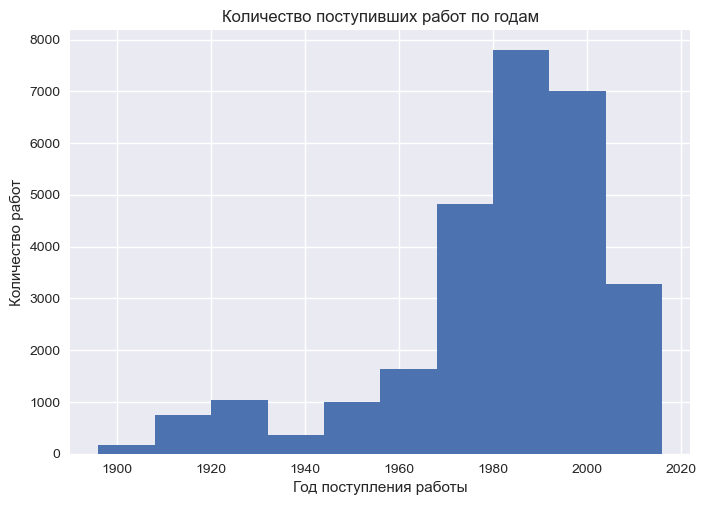

In [29]:
plt.style.use('seaborn')

df['date_acquired'].hist()
plt.xlabel('Год поступления работы')
plt.ylabel('Количество работ')
plt.title('Количество поступивших работ по годам');

По графику видим, что наибольшее количество работ поступило в музей в __1980-1990 гг.__

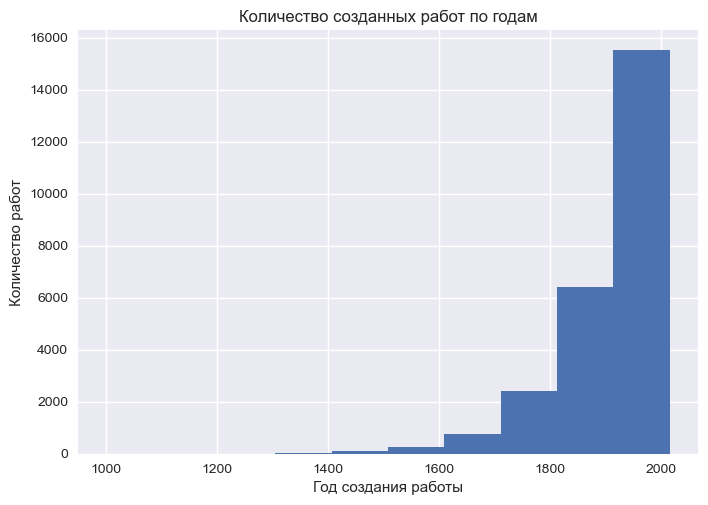

In [30]:
df['creation_date'].hist()
plt.xlabel('Год создания работы')
plt.ylabel('Количество работ')
plt.title('Количество созданных работ по годам');

По графику видно, что у музея отрицательная зависимость между количеством работ и их возрастом: в музее большее количество более новых объектов

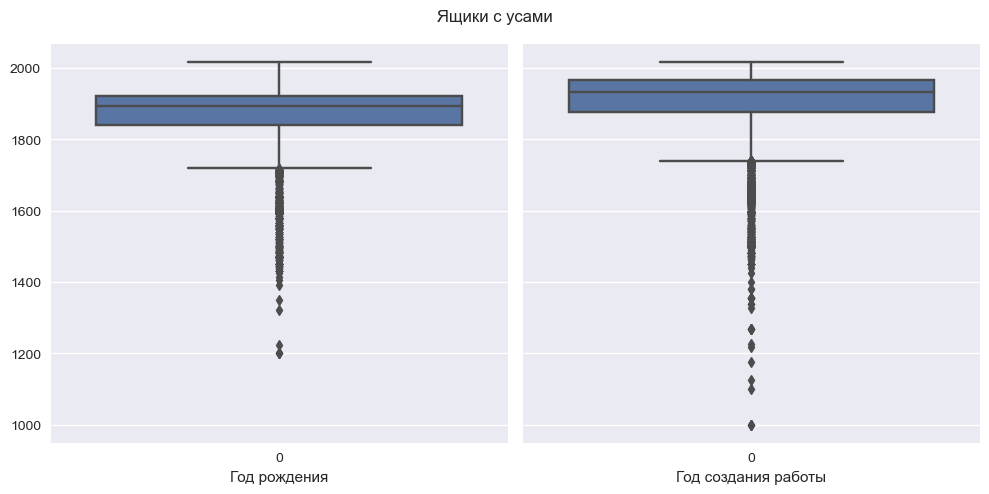

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

sns.boxplot(list(df['birth_date']), ax=axes[0])

sns.boxplot(list(df['creation_date']), ax=axes[1])

axes[0].set_xlabel('Год рождения')
axes[1].set_xlabel('Год создания работы')

plt.suptitle('Ящики с усами')

plt.tight_layout()
plt.show()

In [32]:
median_birth = df["birth_date"].median()
median_creation = df["creation_date"].median()

av_birth = df["birth_date"].mean()
av_creation = df["creation_date"].mean()

print('Медиана года рождения автора', median_birth)
print('Медиана года создания работы', median_creation)
print('Разница', median_creation - median_birth, '\n')

print('Средний год рождения автора', av_birth)
print('Средний год создания работы', av_creation)

Медиана года рождения автора 1892.0
Медиана года создания работы 1931.0
Разница 39.0 

Средний год рождения автора 1866.2267431439327
Средний год создания работы 1904.296534168788


По графикам видно, что для переменных года рождения и года создания работы характерны выбросы снизу. Это подтверждают и вычисления: средний год меньше медианного года. 

По графикам также видно, что медиана (квантиль 0,5) года создания выше, чем медиана года рождения на 39 лет. Можно сказать, что медианный возраст, в котором авторы выполняют работу составляет 39 лет.

## Самая большая работа

In [33]:
mask = df['square'].sort_values(ascending=False)[:5].index
df.loc[mask]

,title,classification,date_acquired,creation_date,medium,item_width,item_height,item_depth,birth_date,nationality,square
20357,"Wall Drawing #450, A wall is divided verticall...",drawings and watercolors,1985.0,1985.0,Lascaux acrylic wash,864.0,354.00,0.0,1928.0,American,305856.0
1257,Magma Spirit Explodes. Tsunami is Dreadful.,installations,2006.0,2004.0,CD,1296.0,192.00,0.0,1974.0,Japanese,248832.0
19369,Pittsburgh Variations,sculpture,1984.0,1984.0,painted aluminum,480.0,360.00,0.0,1912.0,American,172800.0
12755,Forbes Avenue,drawings and watercolors,1970.0,1970.0,charcoal on paper,358.0,451.25,0.0,1946.0,American,161547.5
19371,Piazza Lavoro,sculpture,1984.0,1984.0,"cast concrete, mosaic and terrazzo",600.0,264.00,0.0,1948.0,American,158400.0


К сожалению, датасет даже после обработки содержит некоторые неточности, например, объемные фигуры, такие как скульптуры не имеют размерность __item_depth__, поэтому придется в ручном формате отбирать данные

In [34]:
biggest = [20357, 1257, 12755]
df.loc[biggest]

,title,classification,date_acquired,creation_date,medium,item_width,item_height,item_depth,birth_date,nationality,square
20357,"Wall Drawing #450, A wall is divided verticall...",drawings and watercolors,1985.0,1985.0,Lascaux acrylic wash,864.0,354.00,0.0,1928.0,American,305856.0
1257,Magma Spirit Explodes. Tsunami is Dreadful.,installations,2006.0,2004.0,CD,1296.0,192.00,0.0,1974.0,Japanese,248832.0
12755,Forbes Avenue,drawings and watercolors,1970.0,1970.0,charcoal on paper,358.0,451.25,0.0,1946.0,American,161547.5


In [35]:
print('\033[1m' + 'Самые большие 2D - работы:' + '\033[0m', '\n')

biggest = list(df.loc[biggest]['title'])
for i in range(len(biggest)):
    print(f'{i+1}. {biggest[i]}')

Самые большие 2D - работы: 

1. Wall Drawing #450, A wall is divided vertically into four equal parts.  All one-, two-, three-, and four-part combinations of four colors
2. Magma Spirit Explodes. Tsunami is Dreadful.
3. Forbes Avenue


Ниже представлена самая большая работа

![Wall Drawing #450](https://cmoa-collection-images.s3.amazonaws.com/thing/56525/sizes/1025704-1026077-03-e-1680.jpg)

In [36]:
df.head()

,title,classification,date_acquired,creation_date,medium,item_width,item_height,item_depth,birth_date,nationality,square
0,Keith Haring,photographs,2002.0,1984.0,gelatin silver print,23.250,29.250,1.25,1947.0,American,NaN
1,Untitled,paintings,2002.0,1964.0,oil on canvas,60.500,48.250,2.25,1929.0,American,NaN
2,Trans East West (Tew) No. 5: The Attack of the...,drawings and watercolors,2002.0,1999.0,mixed media on paper,7.500,5.125,0.00,1963.0,German,38.43750
3,Trans East West (Tew) No. 6: Rebuilding Beyrut,drawings and watercolors,2002.0,1999.0,mixed media on paper,7.438,5.125,0.00,1963.0,German,38.11975
4,Trans East West (Tew) No. 7: Bombing the Power...,drawings and watercolors,2002.0,1999.0,mixed media on paper,7.500,5.125,0.00,1963.0,German,38.43750


## Распределение по странам авторов

In [37]:
states = df[['title', 'nationality']].groupby(by='nationality').agg('count').reset_index()
states.columns = ['nationality', 'count']
states.sort_values(by='count', ascending=False, inplace=True)

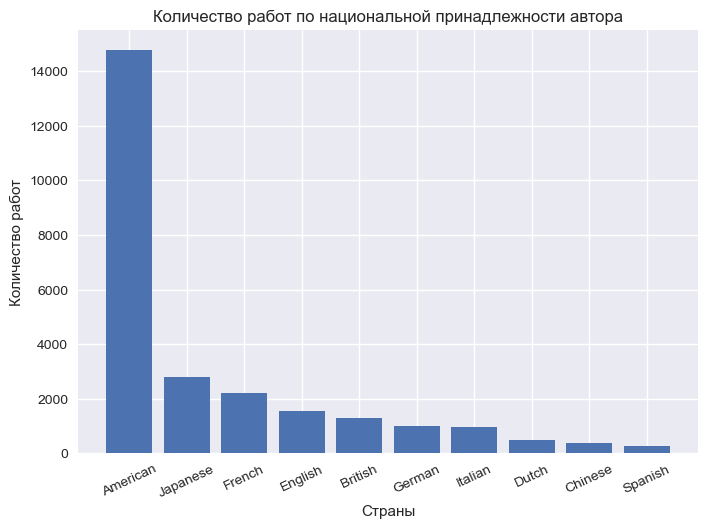

In [38]:
plt.bar(x = states[:10]['nationality'], height=states[:10]['count'])
plt.xlabel('Страны')
plt.ylabel('Количество работ')
plt.xticks(rotation = 25)
plt.title('Количество работ по национальной принадлежности автора');

In [39]:
states[:2]

,nationality,count
5,American,14774
69,Japanese,2803


In [40]:
print('Отрыв между топ-1 и топ-2:', states.loc[5]['count'] - states.loc[69]['count'])

Отрыв между топ-1 и топ-2: 11971


Для выполнения сделал сводную таблицу и посчитал количество работ по национальной принадлежности автора. На графике представлено топ 10 наиболее встречающихся стран. Самовое большое количество работ создано американцами, далее с отрывом 11971 работ идут японцы с количеством работ в размере 2803 штук.

## Средний год создания работы 

In [93]:
sv_tab = df[['classification', 'date_acquired']].groupby('classification').agg(['mean', 'median', 'std'])['date_acquired']

In [95]:
sv_tab.sort_values(by='mean', ascending=False, inplace=True)
sv_tab.reset_index(inplace=True)

In [103]:
youngest_year = round(sv_tab.loc[0]['mean'])
oldest_year = round(sv_tab.loc[av_year.shape[0]-2]['mean'])

youngest_year_med = round(sv_tab.loc[0]['median'])
oldest_year_med = round(sv_tab.loc[av_year.shape[0]-2]['median'])

youngest_year_std = round(sv_tab.loc[0]['std'], 3)
oldest_year_std = round(sv_tab.loc[av_year.shape[0]-2]['std'], 3)

youngest = sv_tab.loc[0]['classification']
oldest = sv_tab.loc[av_year.shape[0]-2]['classification']

print('В среднем работы категории ', youngest, ' были созданы в ', youngest_year,
      '. \nЭто самый маленький средний год среди всех категорий', sep='')
print(f'Медиана для этой категории: {youngest_year_med}\nСтандартное отклонение: {youngest_year_std}\n')

print('В среднем работы категории ', oldest, ' были созданы в ', oldest_year, 
      '. \nЭто самый большой средний год среди всех категорий', sep='')
print(f'Медиана для этой категории: {oldest_year_med}\nСтандартное отклонение: {oldest_year_std}')

В среднем работы категории architectural drawings были созданы в 2013. 
Это самый маленький средний год среди всех категорий
Медиана для этой категории: 2014
Стандартное отклонение: 4.887

В среднем работы категории printing blocks были созданы в 1925. 
Это самый большой средний год среди всех категорий
Медиана для этой категории: 1922
Стандартное отклонение: 19.337


Как видно по полученным данным, самая молодая категория по среднему - __architectural drawings__, однако также наблюдается смещение вниз из-за выбросов.

Самая возрастная категория - __printing blocks__, которая также смещена вниз

In [104]:
sv_tab.head(5)

,classification,mean,median,std
0,architectural drawings,2013.054054,2014.0,4.887479
1,vehicles (transportation),2013.000000,2013.0,NaN
2,sound art,2012.000000,2012.0,NaN
3,installations,2006.852941,2009.5,8.195092
4,mixed media,2005.258065,2011.0,10.639448


## Часто встречающиеся категории

In [45]:
freq = df['classification'].mode().values[0]

print('Часто встречающейся категорией является:', freq)

Часто встречающейся категорией является: prints


## Зависимость величины работы от года создания

Для начала заменим все нули в колонках __item_width__, __item_height__, __item_depth__ на единицы, так как мы будем использовать объем работы. Нули в таком случае обнулят вычисляемое значение

In [46]:
df_shape = df[['item_width', 'item_height', 'item_depth']].replace(0, 1)
df_shape['volume'] = df_shape['item_width'] * df_shape['item_height'] * df_shape['item_depth']
df_shape['date_acquired'] = df['date_acquired']

df_s = df_shape[['volume', 'date_acquired']]
df_corr = df_s.corr()

In [47]:
df_corr

,volume,date_acquired
volume,1.000000,0.003453
date_acquired,0.003453,1.000000


Как мы видим из расчетов, между переменными годом создания и размером работы не наблюдается линейная взаимосвязь, так как показатель очень мал (0.003453).

Посмотрим как это будет отображаться на диаграмма рассеяния. Чтобы график был более адекватный, уберем очень большие значения размера

In [48]:
df_scatter =  df_s.sort_values(by='volume', ascending = False)[30:]

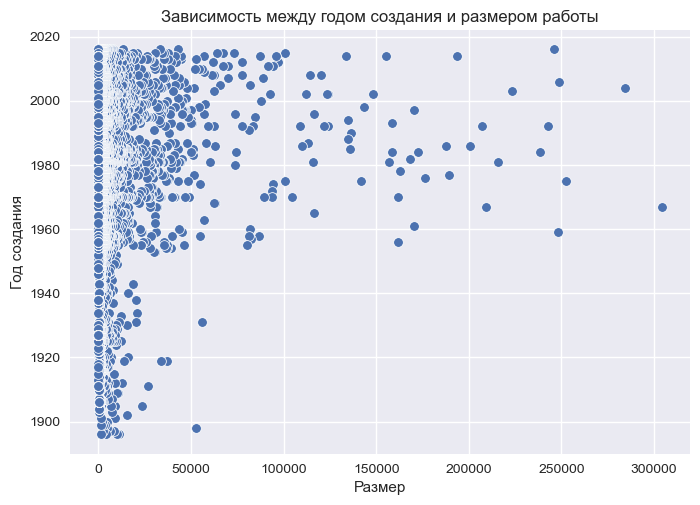

In [49]:
sns.scatterplot(df_scatter, x = 'volume', y = 'date_acquired')
plt.xlabel('Размер')
plt.ylabel('Год создания')
plt.title('Зависимость между годом создания и размером работы');